In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os
import sys
# sys.path.append("/Users/bovy/Repos/tgas-completeness/py/")
import tqdm
import numpy
from scipy.stats import skew, skewtest
from extreme_deconvolution import extreme_deconvolution
os.environ["GAIA_TOOLS_DATA"]="/Users/dkawata/work/obs/gaia_tools/data"
import gaia_tools.load, gaia_tools.xmatch
from galpy.util import bovy_plot, bovy_coords, save_pickles
import effsel # from tgas-completeness
from effsel import main_sequence_cut_r
%pylab inline
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import NullFormatter, FuncFormatter, LogFormatter
from matplotlib import gridspec
import copy
save_figures= False
numpy.random.seed(3)

Populating the interactive namespace from numpy and matplotlib


# The kinematics of local F stars

Load the TGAS and 2MASS data that we use, among other things, select F-type stars:

In [2]:
# Load TGAS and 2MASS
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
dm= -5.*numpy.log10(tgas['parallax'])+10.
mj= twomass['j_mag']-dm

Load the dwarf locus and select TGAS F-type stars with good parallaxes:

In [3]:
# Select F stars
sp= effsel.load_spectral_types()
sptype= 'F'
jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
if sptype == 'M':
    jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
else:
    jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
jmin= main_sequence_cut_r(jkmax)
jmax= main_sequence_cut_r(jkmin)
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > 10.)*(jk != 0.)
good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                *(mj < main_sequence_cut_r(jk,tight=False,low=True))\
                *(mj > main_sequence_cut_r(jk,tight=False))
print("Found %i F stars in TGAS with good parallaxes" % (numpy.sum(good_sampling)))
tgas= tgas[good_sampling]
twomass= twomass[good_sampling]
jk= jk[good_sampling]
dm= dm[good_sampling]
mj=mj[good_sampling]

Found 103603 F stars in TGAS with good parallaxes


In [4]:
rave_cat= gaia_tools.load.rave()
m1,m2,sep= gaia_tools.xmatch.xmatch(rave_cat,tgas,colRA1='RAdeg',colDec1='DEdeg',colRA2='ra',colDec2='dec',
                                    epoch1=2000.,epoch2=2015.,swap=True)
rave_cat= rave_cat[m1]
tgas= tgas[m2]
twomass= twomass[m2]
jk= jk[m2]
dm= dm[m2]
mj= mj[m2]
# Exclude stars with |b| <= 25
indx= numpy.fabs(tgas['b']) > 25.
rave_cat= rave_cat[indx]
tgas= tgas[indx]
twomass= twomass[indx]
jk= jk[indx]
dm= dm[indx]
mj= mj[indx]
print("Found %i F stars in TGASxRAVE with good parallaxes" % (len(tgas)))

Found 10509 F stars in TGASxRAVE with good parallaxes


In [5]:
rave_cat['distance']= rave_cat['distance']/1000.
rave_cat['edistance']= rave_cat['edistance']/1000.
tgas['parallax'][tgas['parallax_error']/tgas['parallax'] > 0.1]= 0.001 # Make sure these get taken out by the distance cut
rave_cat['distance'][rave_cat['distance'] == 0.]= 1./tgas['parallax'][rave_cat['distance'] == 0.]
rave_cat['edistance'][rave_cat['distance'] == 0.]= rave_cat['distance'][rave_cat['distance'] == 0.]\
                     *tgas['parallax_error'][rave_cat['distance'] == 0.]/tgas['parallax'][rave_cat['distance'] == 0.]
tgas_distance=1.0/tgas['parallax']
tgas_edistance=tgas['parallax_error']/(tgas['parallax']**2)

Note that we use TGAS parallax and parallax errors for distance and distance errors.

In [6]:
# Compute XYZUVW for overlap sample using TGAS distance
lb= bovy_coords.radec_to_lb(tgas['ra'],tgas['dec'],degree=True,epoch=None)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],tgas_distance,degree=True)
pmllbb= bovy_coords.pmrapmdec_to_pmllpmbb(tgas['pmra'],tgas['pmdec'],
                                          tgas['ra'],tgas['dec'],degree=True,epoch=None)
vxyz= bovy_coords.vrpmllpmbb_to_vxvyvz(rave_cat['HRV'],pmllbb[:,0],pmllbb[:,1],
                                       XYZ[:,0],XYZ[:,1],XYZ[:,2],
                                       XYZ=True,degree=True)

Compute uncertainties on $(v_X,v_Y,v_Y)$ using Monte Carlo sampling of the parallax and proper motion uncertainties (taking into account the correlation matrix):

In [7]:
nmc= 1001
# Need to sample from the (parallax,proper-motion covariance matrix)
plxpm_mc= numpy.empty((len(tgas),3,nmc))
plxpm_mc[:,0,:]= numpy.atleast_2d(tgas['parallax']).T
plxpm_mc[:,1,:]= numpy.atleast_2d(tgas['pmra']).T
plxpm_mc[:,2,:]= numpy.atleast_2d(tgas['pmdec']).T
for ii in range(len(tgas)):
    # Construct covariance matrixx
    tcov= numpy.zeros((3,3))
    tcov[0,0]= tgas['parallax_error'][ii]**2./2. # /2 because of symmetrization below
    tcov[1,1]= tgas['pmra_error'][ii]**2./2.
    tcov[2,2]= tgas['pmdec_error'][ii]**2./2.
    tcov[0,1]= tgas['parallax_pmra_corr'][ii]*tgas['parallax_error'][ii]*tgas['pmra_error'][ii]
    tcov[0,2]= tgas['parallax_pmdec_corr'][ii]*tgas['parallax_error'][ii]*tgas['pmdec_error'][ii]
    tcov[1,2]= tgas['pmra_pmdec_corr'][ii]*tgas['pmra_error'][ii]*tgas['pmdec_error'][ii]
    # symmetrize
    tcov= (tcov+tcov.T)
    # Cholesky decomp.
    L= numpy.linalg.cholesky(tcov)
    plxpm_mc[ii]+= numpy.dot(L,numpy.random.normal(size=(3,nmc)))

In [8]:
lbtile= numpy.tile(lb,(nmc,1))
XYZ_sam= bovy_coords.lbd_to_XYZ(lbtile[:,0],lbtile[:,1],(1./plxpm_mc[:,0,:]).T.flatten(),degree=True)
ratile= numpy.tile(tgas['ra'],(nmc,1)).flatten()
dectile= numpy.tile(tgas['dec'],(nmc,1)).flatten()
pmllbb_sam= bovy_coords.pmrapmdec_to_pmllpmbb(plxpm_mc[:,1,:].T.flatten(),plxpm_mc[:,2,:].T.flatten(),
                                              ratile,dectile,degree=True,epoch=None)
vxyz_sam= bovy_coords.vrpmllpmbb_to_vxvyvz((numpy.atleast_2d(rave_cat['HRV']).T\
                                               +numpy.random.normal(size=nmc)\
                                               *numpy.atleast_2d(rave_cat['eHRV']).T).T.flatten(),
                                           pmllbb_sam[:,0],pmllbb_sam[:,1],
                                           XYZ_sam[:,0],XYZ_sam[:,1],XYZ_sam[:,2],
                                           XYZ=True,degree=True)
vxyz_sam= vxyz_sam.reshape((nmc,len(tgas),3))
vxyz_err= numpy.std(vxyz_sam,axis=0)
vxyz_mean= numpy.mean(vxyz_sam,axis=0)
vxyz_skew= skewtest(vxyz_sam[:,:,2],axis=0) #vxyz_skew[1] = P(Gaussian, not skewed)

A comparison between the MC samples and the Gaussian approximation for two stars...

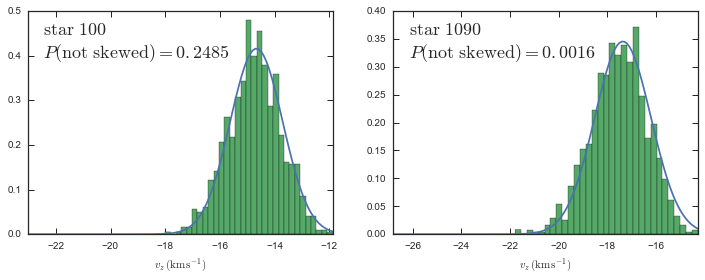

In [9]:
figsize(12,4)
subplot(1,2,1)
ii= 100
xs= numpy.linspace(-50.,50.,1001)
ys= numpy.exp(-0.5*(xs-vxyz[ii,2])**2./vxyz_err[ii,2]**2.)
ys/= numpy.sum(ys)*(xs[1]-xs[0])
plot(xs,ys)
_= hist(vxyz_sam[:,ii,2],bins=31,normed=True)
xlim(numpy.amin(vxyz_sam[:,ii,2])-5.,numpy.amax(vxyz_sam[:,ii,2]))
bovy_plot.bovy_text(r'$\mathrm{star\ %i}$' % ii +'\n'
                    +r'$P(\mathrm{not\ skewed}) = %.4f$' % (skewtest(vxyz_sam[:,ii,2])[1]),top_left=True,size=18.)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')
subplot(1,2,2)
ii= 1090
xs= numpy.linspace(-50.,50.,1001)
ys= numpy.exp(-0.5*(xs-vxyz[ii,2])**2./vxyz_err[ii,2]**2.)
ys/= numpy.sum(ys)*(xs[1]-xs[0])
plot(xs,ys)
_= hist(vxyz_sam[:,ii,2],bins=31,normed=True)
xlim(numpy.amin(vxyz_sam[:,ii,2])-5.,numpy.amax(vxyz_sam[:,ii,2]))
bovy_plot.bovy_text(r'$\mathrm{star\ %i}$' % ii +'\n'
                    +r'$P(\mathrm{not\ skewed}) = %.4f$' % (skewtest(vxyz_sam[:,ii,2])[1]),top_left=True,size=18.)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')

The distribution of uncertainties in $v_z$ is:

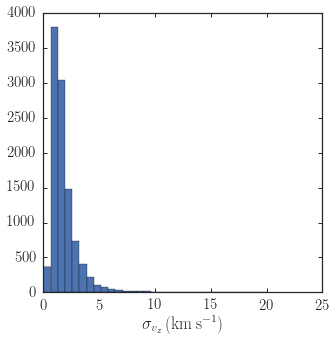

In [10]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
_= hist(vxyz_err[:,2],bins=31,range=[0.,20.])
xlabel(r'$\sigma_{v_z}\,(\mathrm{km\,s}^{-1})$')

The vertical velocity distribution is:

/Users/dkawata/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

Selecting 6485 out of 10509 stars for vz fit
 input shape= (6485, 1) (6485,)
 initial guess of median, sig= -7.1308268707 12.7719004084
('lnL, symmetric', -4.118355692937629)
('amp, mean, std. dev.', array([ 0.69733494,  0.00650826,  0.2961568 ]), array([-6.4, -6.4, -6.4]), array([  10.39533095,  375.64682517,   20.54526833]))
('Combined <v^2>, sqrt(<v^2>):', 201.67878790559021, 14.201365705649236)
('lnL', -4.116157652017397)
('amp, mean, std. dev.', array([ 0.68872295,  0.00655506,  0.30472199]), array([ -6.31834058, -63.43189218,  -9.33053644]), array([  10.31962591,  370.05544204,   20.19707859]))
('Combined <v^2>, sqrt(<v^2>):', 200.88169367110282, 14.173273922107864)


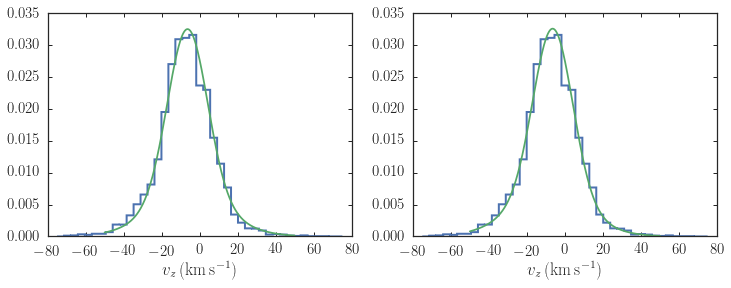

In [11]:
figsize(12,4)
def combined_sig2(amp,mean,covar):
    indx= numpy.sqrt(covar) < 30.
    tamp= amp[indx]/numpy.sum(amp[indx])
    return (numpy.sum(tamp*(covar+mean**2.)[indx])-numpy.sum(tamp*mean[indx])**2.)
indx= (True-numpy.any(numpy.isnan(vxyz),axis=1))\
    *(numpy.fabs(XYZ[:,2]) < .4)\
    *(numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.) < 0.2)\
    *(True-numpy.isnan(vxyz_err[:,2]))
#    *(True-numpy.isnan(vxyz_err[:,2]))\
#    *(vxyz_skew[1] > 0.05)
print("Selecting %i out of %i stars for vz fit" % (numpy.sum(indx),len(tgas)))
subplot(1,2,1)
_= bovy_plot.bovy_hist(vxyz[indx,2],bins=41,range=[-75.,75.],
                       histtype='step',lw=2.,normed=True,overplot=True)
# Fit with mix of Gaussians
ydata= numpy.atleast_2d(vxyz[indx,2]).T
ycovar= vxyz_err[indx,2]**2.
print ' input shape=',ydata.shape,ycovar.shape
ngauss= 3
initamp= numpy.random.uniform(size=ngauss)
initamp/= numpy.sum(initamp)
m= numpy.median(vxyz[indx,2])
s= 1.4826*numpy.median(numpy.fabs(vxyz[indx,2]-m))
print ' initial guess of median, sig=',m,s
initmean= []
initcovar= []
# Symmetric fit first, fix means to be the same at ~good value
for ii in range(ngauss):
    initcovar.append(s**2.)
initcovar= numpy.array([[initcovar]]).T
initmean= numpy.array([[-6.4 for ii in range(ngauss)]]).T
print("lnL, symmetric",extreme_deconvolution(ydata,ycovar,initamp,initmean,initcovar,fixmean=True))
print("amp, mean, std. dev.",initamp,initmean[:,0],numpy.sqrt(initcovar[:,0,0]))
print("Combined <v^2>, sqrt(<v^2>):",combined_sig2(initamp,initmean[:,0],initcovar[:,0,0]),
      numpy.sqrt(combined_sig2(initamp,initmean[:,0],initcovar[:,0,0])))
xs= numpy.linspace(-50.,50.,1001)
ys= numpy.sum(numpy.atleast_2d(initamp/numpy.sqrt(initcovar[:,0,0])).T\
              *numpy.exp(-0.5*(xs-numpy.atleast_2d(initmean[:,0]).T)**2./numpy.atleast_2d(initcovar[:,0,0]).T),axis=0)\
            /numpy.sqrt(2.*numpy.pi)
plot(xs,ys)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')
# Now let the means vary
ngauss= 3
subplot(1,2,2)
_= bovy_plot.bovy_hist(vxyz[indx,2],bins=41,range=[-75.,75.],
                       histtype='step',lw=2.,normed=True,overplot=True)
initmean= []
for ii in range(ngauss):
    initmean.append(m+numpy.random.normal()*s)
initmean= numpy.array([initmean]).T
print("lnL",extreme_deconvolution(ydata,ycovar,initamp,initmean,initcovar))
xs= numpy.linspace(-50.,50.,1001)
ys= numpy.sum(numpy.atleast_2d(initamp/numpy.sqrt(initcovar[:,0,0])).T\
              *numpy.exp(-0.5*(xs-numpy.atleast_2d(initmean[:,0]).T)**2./numpy.atleast_2d(initcovar[:,0,0]).T),axis=0)\
            /numpy.sqrt(2.*numpy.pi)
plot(xs,ys)
print("amp, mean, std. dev.",initamp,initmean[:,0],numpy.sqrt(initcovar[:,0,0]))
print("Combined <v^2>, sqrt(<v^2>):",combined_sig2(initamp,initmean[:,0],initcovar[:,0,0]),
      numpy.sqrt(combined_sig2(initamp,initmean[:,0],initcovar[:,0,0])))
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')

The distribution of $(v_z,\sigma_{v_z})$:

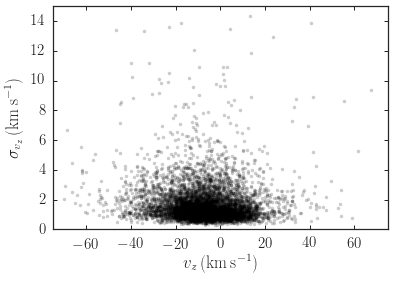

In [12]:
figsize(6,4)
plot(vxyz[indx,2],vxyz_err[indx,2],'k.',alpha=0.2)
xlim(-75.,75.)
ylim(0.,15.)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')
ylabel(r'$\sigma_{v_z}\,(\mathrm{km\,s}^{-1})$')

The $(z,v_z)$ distribution for this sample:

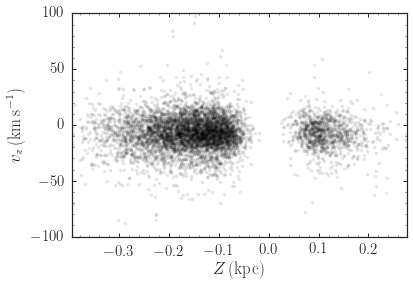

In [13]:
bovy_plot.bovy_plot(XYZ[indx,2],vxyz[indx,2],'k.',alpha=0.1,
                    yrange=[-100.,100.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$v_z\,(\mathrm{km\,s}^{-1})$')

Let's measure $<v^2>$ at different z. First set z grid and bin size for smoothing. Then, pick up stars within the cylinder of $R_{xy}<0.2$ kpc.

In [37]:
z_obs=numpy.arange(-0.4,0.4,0.025)
h_obs= 0.075
indx= (True-numpy.any(numpy.isnan(vxyz),axis=1))\
    *(numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.) < 0.2)\
    *(True-numpy.isnan(vxyz_err[:,2])
# adding this does not change much
#    *(vxyz_skew[1] > 0.05)
print("Selecting %i out of %i stars for vz fit" % (numpy.sum(indx),len(tgas)))
# select data
z_data=XYZ[indx,2]
vz_data=vxyz[indx,2]
vz_err= vxyz_err[indx,2]
figsize(6,4)
bovy_plot.bovy_plot(z_data,vz_data,'k.',alpha=0.1,
                    yrange=[-100.,100.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$v_z\,(\mathrm{km\,s}^{-1})$')

SyntaxError: invalid syntax (<ipython-input-37-1ddabe9081a1>, line 6)

In [38]:
# define compute <v^2> using XD.
def compute_xdv2(z,vz,vz_err,z_obs,h_obs):
    v2=numpy.zeros_like(z_obs)
    lnL=numpy.zeros_like(z_obs)
    np=numpy.zeros(len(z_obs))
    # set up for multiple Gaussian fits
    ngauss= 3
    # initamp= numpy.random.uniform(size=ngauss)
    initamp=numpy.ones(ngauss)
    initamp/= numpy.sum(initamp)
    m= numpy.median(vz)
    s= 1.4826*numpy.median(numpy.fabs(vz-m))
    initmean= []
    initcovar= []
    for ii in range(ngauss):
        initcovar.append(s**2.)
    initcovar= numpy.array([[initcovar]]).T
    for ii in range(ngauss):
        initmean.append(m+numpy.random.normal()*s)
    initmean= numpy.array([initmean]).T
    for jj,zo in enumerate(z_obs):
        indx= numpy.fabs(z-zo)<h_obs
        # print ' nstar=',len(z[indx])
        np[jj]=len(z[indx])
        if len(z[indx])>25:
            vz_xddata= numpy.atleast_2d(vz[indx]).T
            vz_covar=vz_err[indx]**2
            # print ' shape=',vz_xddata.shape,vz_covar.shape
            lnL[jj]=extreme_deconvolution(vz_xddata,vz_covar,initamp,initmean,initcovar)
            # print("zobs, amp, mean, std. dev.",zo,initamp,initmean[:,0],numpy.sqrt(initcovar[:,0,0]))
            v2[jj]=combined_sig2(initamp,initmean[:,0],initcovar[:,0,0])
            print("z, amp, mean, std. dev.",zo,initamp,initmean[:,0],numpy.sqrt(initcovar[:,0,0]))
            # test plots
            _= bovy_plot.bovy_hist(vz[indx],bins=41,range=[-75.,75.],
                            histtype='step',lw=2.,normed=True,overplot=True)
            xs= numpy.linspace(-50.,50.,1001)
            ys= numpy.sum(numpy.atleast_2d(initamp/numpy.sqrt(initcovar[:,0,0])).T\
               *numpy.exp(-0.5*(xs-numpy.atleast_2d(initmean[:,0]).T)**2./numpy.atleast_2d(initcovar[:,0,0]).T),axis=0)\
               /numpy.sqrt(2.*numpy.pi)
            plot(xs,ys)
            xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')
            show()
        else:
            v2[jj]=0.0
    return (v2,lnL,np)

Calcuate $<v^2>$ using XD.

('z, amp, mean, std. dev.', -0.40000000000000002, array([ 0.19446331,  0.10942245,  0.69611424]), array([-12.10408514, -30.01611218,  -3.00701385]), array([ 26.14793721,   4.2729376 ,  10.45948653]))


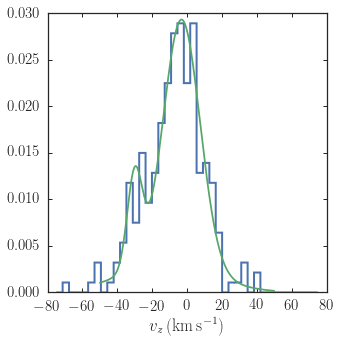

('z, amp, mean, std. dev.', -0.375, array([ 0.25508712,  0.07636811,  0.66854477]), array([-12.81382219, -26.98775688,  -3.93783855]), array([ 23.248051  ,   3.35039098,  11.11002875]))


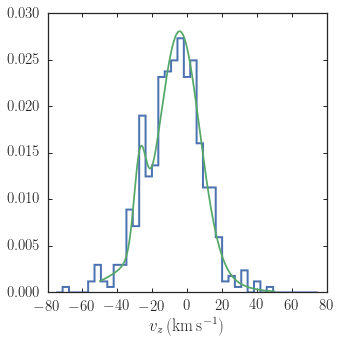

('z, amp, mean, std. dev.', -0.34999999999999998, array([ 0.0014245 ,  0.02016932,  0.97840618]), array([-769.45472486,  -26.55702589,   -7.59311591]), array([  2.53016722,   0.372402  ,  15.70155802]))


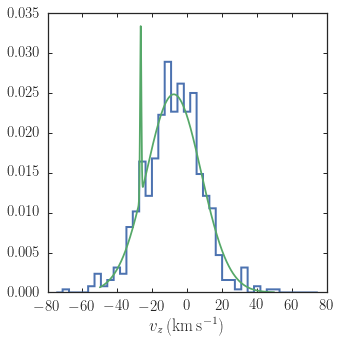

('z, amp, mean, std. dev.', -0.32499999999999996, array([  9.38086304e-04,   9.78185211e-03,   9.89280062e-01]), array([-769.45739406,  -26.33637764,   -7.60377309]), array([  2.14434986,   0.32751092,  22.70175421]))


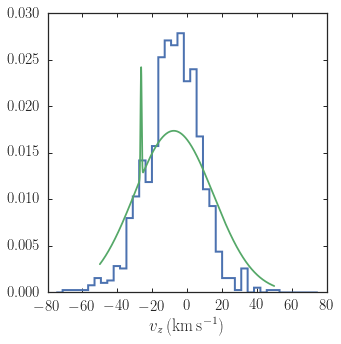

('z, amp, mean, std. dev.', -0.29999999999999993, array([ 0.01024945,  0.00196199,  0.98778856]), array([-152.98488103,  -26.44316165,   -7.70950804]), array([  3.20315662e+02,   3.11830791e-01,   1.46239227e+01]))


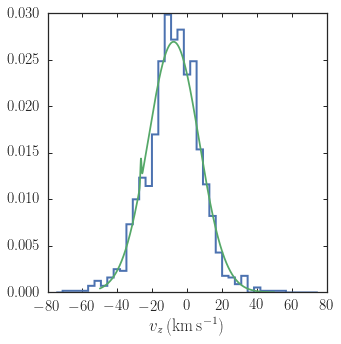

('z, amp, mean, std. dev.', -0.27499999999999991, array([  1.01403014e-02,   2.10382949e-04,   9.89649316e-01]), array([-109.27749938,  -26.47267541,   -7.57424894]), array([ 294.45651446,    0.30438955,   14.53618713]))


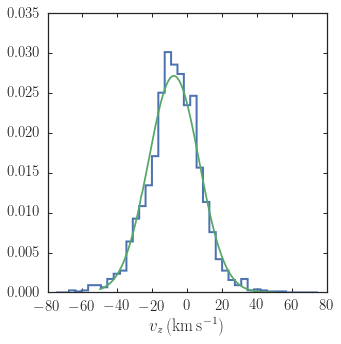

('z, amp, mean, std. dev.', -0.24999999999999989, array([  9.83802352e-03,   4.34943367e-05,   9.90118482e-01]), array([-43.05494824, -26.48886663,  -7.33929778]), array([  3.48611154e+02,   2.96708640e-01,   1.44398173e+01]))


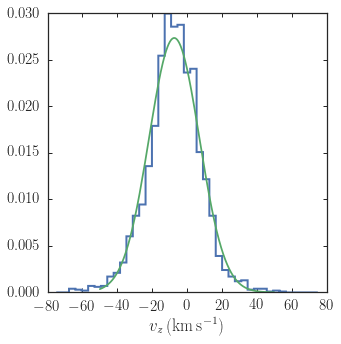

('z, amp, mean, std. dev.', -0.22499999999999987, array([  8.92070760e-03,   1.25679074e-05,   9.91066724e-01]), array([-36.85379924, -26.50523894,  -7.16811025]), array([  3.28576833e+02,   2.93306496e-01,   1.41198515e+01]))


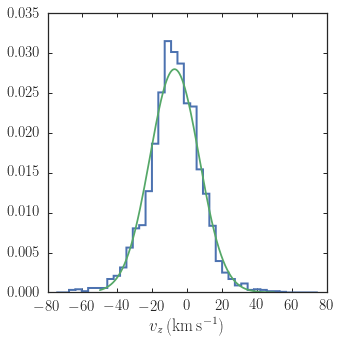

('z, amp, mean, std. dev.', -0.19999999999999984, array([  8.87932244e-03,   5.30646971e-06,   9.91115371e-01]), array([-33.84945079, -26.51768432,  -7.07800373]), array([  3.14985082e+02,   2.90810558e-01,   1.41526064e+01]))


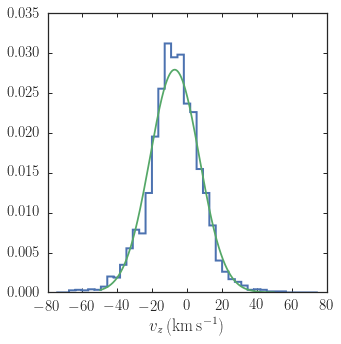

('z, amp, mean, std. dev.', -0.17499999999999982, array([  1.16244804e-02,   7.28303615e-07,   9.88374791e-01]), array([-17.23121647, -26.55071372,  -7.02456148]), array([  2.89271631e+02,   2.84016707e-01,   1.37989516e+01]))


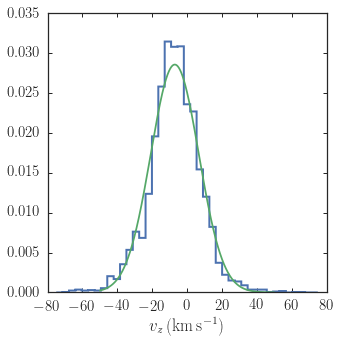

('z, amp, mean, std. dev.', -0.1499999999999998, array([  1.22431999e-02,   1.49698650e-07,   9.87756650e-01]), array([-12.17541862, -26.57768961,  -7.02099765]), array([ 270.72399768,    0.27882354,   13.71328507]))


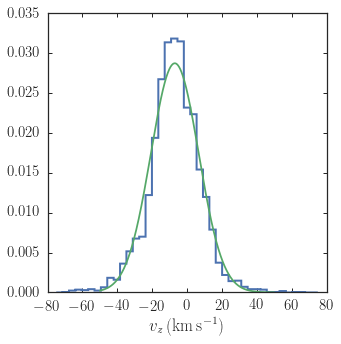

('z, amp, mean, std. dev.', -0.12499999999999978, array([  1.25162542e-02,   3.88686069e-08,   9.87483707e-01]), array([-19.589014  , -26.60357306,  -6.93204806]), array([ 272.25337583,    0.27394609,   13.64866918]))


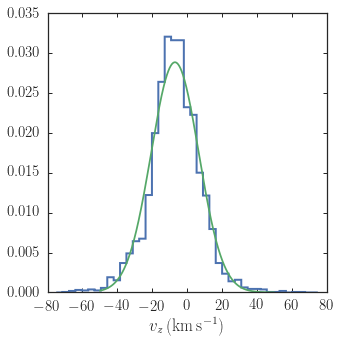

('z, amp, mean, std. dev.', -0.099999999999999756, array([  1.20074726e-02,   1.43117353e-08,   9.87992513e-01]), array([ 21.12040886, -26.61858272,  -6.90815785]), array([ 257.64405643,    0.26964409,   13.65550271]))


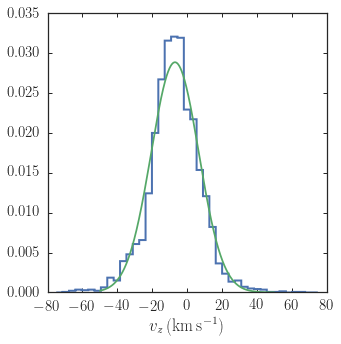

('z, amp, mean, std. dev.', -0.074999999999999734, array([  1.18691838e-02,   5.22732833e-09,   9.88130811e-01]), array([ 25.18896627, -26.63858068,  -6.86353512]), array([  2.75524397e+02,   2.63861531e-01,   1.35434073e+01]))


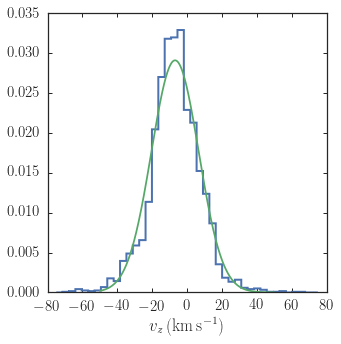

('z, amp, mean, std. dev.', -0.049999999999999711, array([  1.26984225e-02,   6.69204068e-10,   9.87301577e-01]), array([ -5.33882424, -26.68778329,  -6.88878306]), array([ 228.47025748,    0.2520805 ,   13.34675729]))


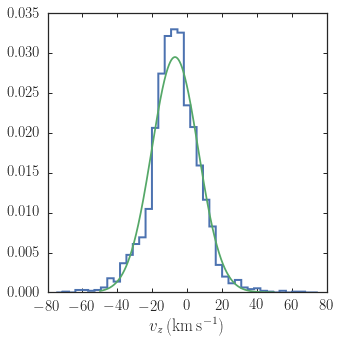

('z, amp, mean, std. dev.', -0.024999999999999689, array([  1.59922793e-02,   9.85405889e-11,   9.84007721e-01]), array([-10.21951381, -26.72334155,  -6.80878481]), array([ 233.38572579,    0.24220391,   13.25910423]))


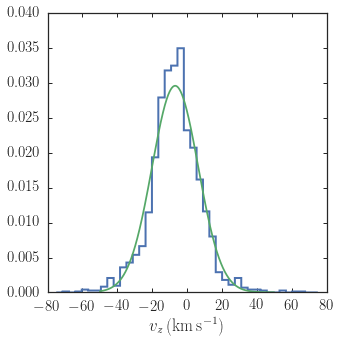

('z, amp, mean, std. dev.', 3.3306690738754696e-16, array([  2.21230045e-02,   1.79157208e-11,   9.77876995e-01]), array([-11.29249097, -26.73843407,  -6.93968529]), array([ 211.97381682,    0.23033498,   12.11327499]))


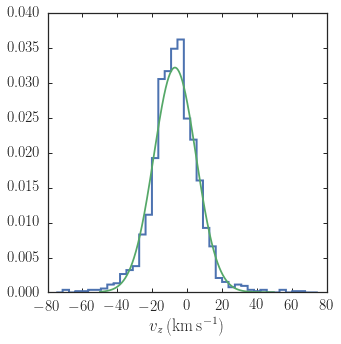

('z, amp, mean, std. dev.', 0.025000000000000355, array([  1.75591863e-02,   4.82787260e-12,   9.82440814e-01]), array([-41.08449135, -26.73317742,  -6.89690945]), array([ 185.44235642,    0.22172765,   11.88097439]))


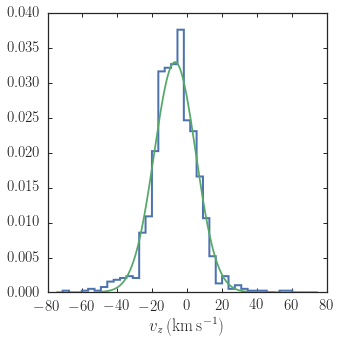

('z, amp, mean, std. dev.', 0.050000000000000377, array([  1.21957883e-02,   3.88450314e-13,   9.87804212e-01]), array([-77.21434712, -26.67127532,  -6.93743473]), array([  2.54854402e+02,   2.20062425e-01,   1.17465697e+01]))


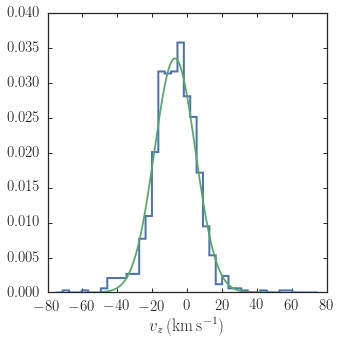

('z, amp, mean, std. dev.', 0.0750000000000004, array([  1.07653789e-02,   5.43253912e-14,   9.89234621e-01]), array([-98.45741461, -26.62628164,  -7.10850385]), array([ 186.8810765 ,    0.21781487,   11.80136393]))


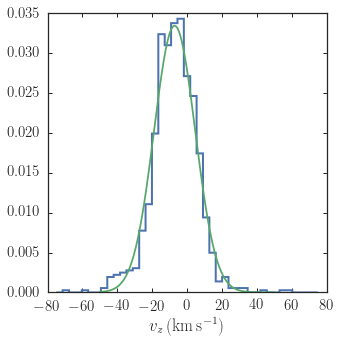

('z, amp, mean, std. dev.', 0.10000000000000042, array([  1.01250906e-02,   1.34092743e-14,   9.89874909e-01]), array([-98.9151222 , -26.60140538,  -7.26714795]), array([ 187.44381961,    0.21558827,   11.83614373]))


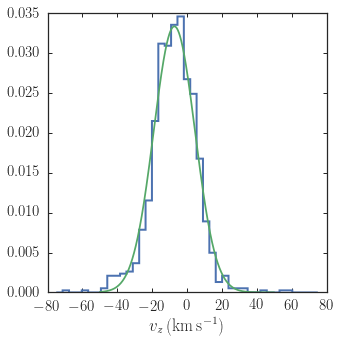

('z, amp, mean, std. dev.', 0.12500000000000044, array([  1.40562611e-02,   6.32327936e-16,   9.85943739e-01]), array([-72.9927627 , -26.54900131,  -7.36222081]), array([ 156.80760398,    0.211182  ,   11.89577173]))


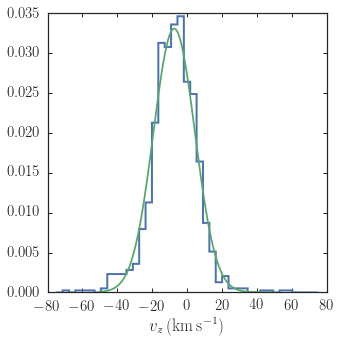

('z, amp, mean, std. dev.', 0.15000000000000047, array([  1.49784844e-02,   4.13058829e-17,   9.85021516e-01]), array([-114.33172555,  -26.5023456 ,   -7.4967342 ]), array([  2.10098089e+02,   2.06460706e-01,   1.19424562e+01]))


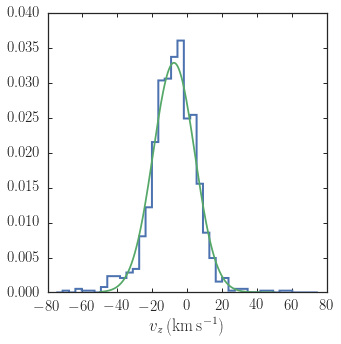

('z, amp, mean, std. dev.', 0.17500000000000049, array([  1.48756720e-02,   5.45295236e-18,   9.85124328e-01]), array([-123.68652993,  -26.46635682,   -7.98683598]), array([  2.25167032e+02,   2.01734833e-01,   1.20771173e+01]))


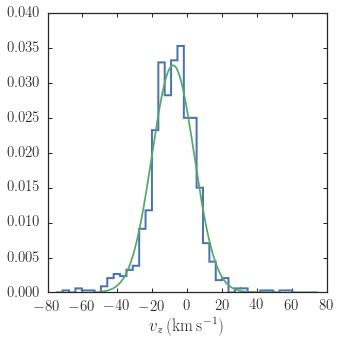

('z, amp, mean, std. dev.', 0.20000000000000051, array([  1.16442824e-02,   4.12848915e-19,   9.88355718e-01]), array([-199.01659205,  -26.4375169 ,   -8.4627865 ]), array([  2.84047371e+02,   1.97199112e-01,   1.24873890e+01]))


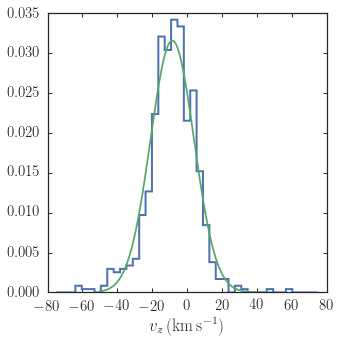

('z, amp, mean, std. dev.', 0.22500000000000053, array([  1.36535997e-02,   6.00730229e-21,   9.86346400e-01]), array([-291.65049135,  -26.42878814,   -9.25423481]), array([  3.00341889e+02,   1.93491870e-01,   1.31583778e+01]))


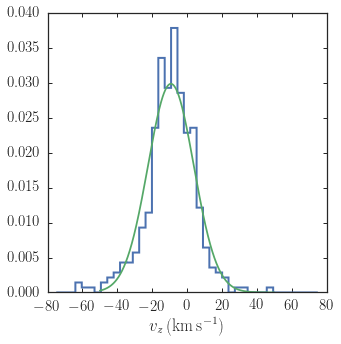

('z, amp, mean, std. dev.', 0.25000000000000056, array([  1.97245220e-02,   1.05638382e-22,   9.80275478e-01]), array([-199.50176044,  -26.46570033,   -9.5900712 ]), array([  2.60612313e+02,   1.91832949e-01,   1.36868609e+01]))


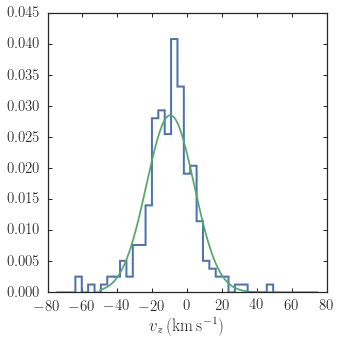

('z, amp, mean, std. dev.', 0.27500000000000058, array([  9.43396226e-03,   5.26207774e-47,   9.90566038e-01]), array([-671.11471372,  -26.67576191,  -10.72355938]), array([  7.15261064,   0.18487758,  16.4888986 ]))


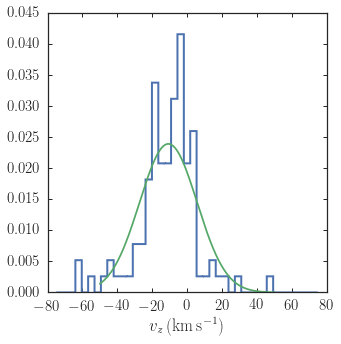

('z, amp, mean, std. dev.', 0.3000000000000006, array([  2.04081633e-02,   5.70695765e-67,   9.79591837e-01]), array([-671.14086547,  -25.66198391,  -11.44196422]), array([  5.93049152,   0.14048649,  20.79485296]))


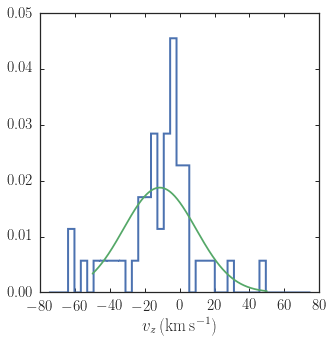

 z,<v^2>^1/2,lnL,np= -0.4 16.8732393689 -4.22263604702 256.0
 z,<v^2>^1/2,lnL,np= -0.375 16.3009134765 -4.20999281704 462.0
 z,<v^2>^1/2,lnL,np= -0.35 32.759030531 -4.21428624588 702.0
 z,<v^2>^1/2,lnL,np= -0.325 32.5109442697 -4.62815352191 1066.0
 z,<v^2>^1/2,lnL,np= -0.3 14.6331706916 -4.20307113786 1541.0
 z,<v^2>^1/2,lnL,np= -0.275 14.5372534696 -4.19346253091 2112.0
 z,<v^2>^1/2,lnL,np= -0.25 14.4400580608 -4.18490803934 2737.0
 z,<v^2>^1/2,lnL,np= -0.225 14.1199298951 -4.15537384606 3421.0
 z,<v^2>^1/2,lnL,np= -0.2 14.1526400044 -4.15460483755 4122.0
 z,<v^2>^1/2,lnL,np= -0.175 13.7989566915 -4.14477717462 4582.0
 z,<v^2>^1/2,lnL,np= -0.15 13.7132861427 -4.13979803008 4641.0
 z,<v^2>^1/2,lnL,np= -0.125 13.6486694736 -4.13651639266 4324.0
 z,<v^2>^1/2,lnL,np= -0.1 13.6555028165 -4.13171214423 3849.0
 z,<v^2>^1/2,lnL,np= -0.075 13.5434073391 -4.12298241015 3266.0
 z,<v^2>^1/2,lnL,np= -0.05 13.346757294 -4.10957997953 2625.0
 z,<v^2>^1/2,lnL,np= -0.025 13.2591042349 -4.1216309312 1

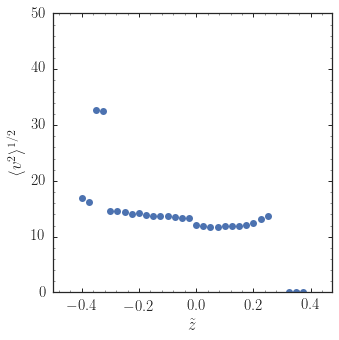

In [39]:
v2m_obs,lnL,nstar =compute_xdv2(z_data,vz_data,vz_err,z_obs,h_obs)
for ii,zo in enumerate(z_obs):
    print ' z,<v^2>^1/2,lnL,np=',zo,numpy.sqrt(v2m_obs[ii]),lnL[ii],nstar[ii]
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
bovy_plot.bovy_plot(z_obs,numpy.sqrt(v2m_obs),'o',semilogy=False,
  xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle^{1/2}$',
  xrange=[np.min(z_obs)-h_obs,np.max(z_obs)+h_obs],yrange=[0.0,50.0],gcf=True)
# plt.errorbar(z_obs,numpy.sqrt(v2m_obs),yerr=numpy.sqrt(v2m_obs_noise),marker='None',ls='none',color=sns.color_palette()[1])

Limit z range between -0.3 and 0.275 where XD is working well.

In [85]:
z_obs=numpy.arange(-0.3,0.325,0.025)
h_obs= 0.075

XD with boortstrap (sampling with replacement).

In [86]:
# compute <v^2> using XD and estimate errors with bootstrap
def compute_xdbsv2(z,vz,vz_err,z_obs,h_obs,nbs):
    v2=numpy.zeros_like(z_obs)
    v2_err=numpy.zeros_like(z_obs)
    lnL=numpy.zeros_like(z_obs)
    np=numpy.zeros(len(z_obs))
    # set up for multiple Gaussian fits
    ngauss= 3
    # initamp= numpy.random.uniform(size=ngauss)
    initamp=numpy.ones(ngauss)
    initamp/= numpy.sum(initamp)
    m= numpy.median(vz)
    s= 1.4826*numpy.median(numpy.fabs(vz-m))
    initmean= []
    initcovar= []
    for ii in range(ngauss):
        initcovar.append(s**2.)
    initcovar= numpy.array([[initcovar]]).T
    for ii in range(ngauss):
        initmean.append(m+numpy.random.normal()*s)
    initmean= numpy.array([initmean]).T
    for jj,zo in enumerate(z_obs):
        indx= numpy.fabs(z-zo)<h_obs
        # print ' nstar=',len(z[indx])
        np[jj]=len(z[indx])
        if len(z[indx])>25:
            # selected sample
            vz_samp=vz[indx]
            vzerr_samp=vz_err[indx]
            nsamp=len(vz_samp)
            # bootstrap
            v2_bs=numpy.zeros(nbs)
            for ii in range(nbs):
                # sampling with replacement
                indxbs=indxsb=list(numpy.random.random_integers(0,nsamp-1,nsamp))
                vz_xddata= numpy.atleast_2d(vz_samp[indxbs]).T
                vz_covar=vzerr_samp[indxbs]**2
                lnLbs=extreme_deconvolution(vz_xddata,vz_covar,initamp,initmean,initcovar)
                v2_bs[ii]=combined_sig2(initamp,initmean[:,0],initcovar[:,0,0])
            v2[jj]=numpy.nanmean(v2_bs)
            v2_err[jj]=numpy.nanstd(v2_bs)
            #print 'z,v2 samp=',zo,v2[jj],v2_err[jj],v2_bs
        else:
            v2[jj]=0.0
            v2_err[jj]=0.0
    return (v2,v2_err,np)

 z,<v^2>^1/2,error,np= -0.3 24.3914166516 18.821496175 1051.0
 z,<v^2>^1/2,error,np= -0.275 26.135719196 11.3956622632 1481.0
 z,<v^2>^1/2,error,np= -0.25 25.2160962972 11.1108040714 1985.0
 z,<v^2>^1/2,error,np= -0.225 23.368317412 14.4200613461 2543.0
 z,<v^2>^1/2,error,np= -0.2 25.1227344308 12.1183837509 3101.0
 z,<v^2>^1/2,error,np= -0.175 23.3905773701 12.9923889762 3676.0
 z,<v^2>^1/2,error,np= -0.15 23.4475799521 11.4029303872 3978.0
 z,<v^2>^1/2,error,np= -0.125 19.0099323254 8.41776587942 3800.0
 z,<v^2>^1/2,error,np= -0.1 22.1931154091 11.175207683 3263.0
 z,<v^2>^1/2,error,np= -0.075 20.5845183556 11.665502635 2593.0
 z,<v^2>^1/2,error,np= -0.05 23.1100101975 10.3708655701 1830.0
 z,<v^2>^1/2,error,np= -0.025 24.4121234711 13.7520159236 1046.0
 z,<v^2>^1/2,error,np= 2.77555756156e-16 20.0442605738 13.0591171803 510.0
 z,<v^2>^1/2,error,np= 0.025 19.6934776597 14.6794694445 494.0
 z,<v^2>^1/2,error,np= 0.05 12.9759869948 4.24021423003 712.0
 z,<v^2>^1/2,error,np= 0.075 13.34

<Container object of 3 artists>

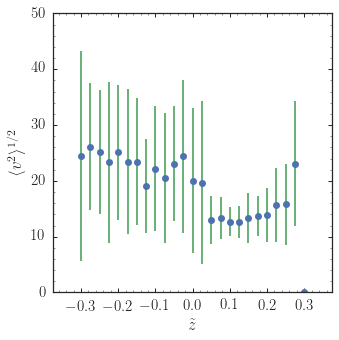

In [87]:
nbs=10  # number of sampling for bootstrap
numpy.random.seed(3)
v2_obs,v2_obs_noise,nstar =compute_xdbsv2(z_data,vz_data,vz_err,z_obs,h_obs,nbs)
for ii,zo in enumerate(z_obs):
    print ' z,<v^2>^1/2,error,np=',zo,numpy.sqrt(v2_obs[ii]),numpy.sqrt(v2_obs_noise[ii]),nstar[ii]
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
bovy_plot.bovy_plot(z_obs,numpy.sqrt(v2_obs),'o',semilogy=False,
  xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle^{1/2}$',
  xrange=[np.min(z_obs)-h_obs,np.max(z_obs)+h_obs],yrange=[0.0,50.0],gcf=True)
errorbar(z_obs,numpy.sqrt(v2_obs),yerr=numpy.sqrt(v2_obs_noise),marker='None',ls='none',color=sns.color_palette()[1])

In [88]:
# compute <v^2> using MAD and estimate errors with bootstrap
def compute_madbsv2(z,vz,vz_err,z_obs,h_obs,nbs):
    v2=numpy.zeros_like(z_obs)
    v2_err=numpy.zeros_like(z_obs)
    np=numpy.zeros(len(z_obs))
    for jj,zo in enumerate(z_obs):
        indx= numpy.fabs(z-zo)<h_obs
        # print ' nstar=',len(z[indx])
        np[jj]=len(z[indx])
        if len(z[indx])>25:
            # selected sample
            vz_samp=vz[indx]
            vzerr_samp=vz_err[indx]
            nsamp=len(vz_samp)
            # bootstrap
            v2_bs=numpy.zeros(nbs)
            for ii in range(nbs):
                # sampling with replacement
                indxbs=indxsb=list(numpy.random.random_integers(0,nsamp-1,nsamp))
                m= numpy.median(vz_samp[indxbs])
                v2_bs[ii]= (1.4826*numpy.median(numpy.fabs(vz_samp[indxbs]-m)))**2
            v2[jj]=numpy.nanmean(v2_bs)
            v2_err[jj]=numpy.nanstd(v2_bs)
            #print 'z,v2 samp=',zo,v2[jj],v2_err[jj],v2_bs
        else:
            v2[jj]=0.0
            v2_err[jj]=0.0
    return (v2,v2_err,np)

 z,<v^2>^1/2,error,np= -0.3 14.7394445256 4.22260696677 1051.0
 z,<v^2>^1/2,error,np= -0.275 13.9853648451 3.55531523711 1481.0
 z,<v^2>^1/2,error,np= -0.25 13.7189592598 3.29602651725 1985.0
 z,<v^2>^1/2,error,np= -0.225 13.5390237046 3.15195092329 2543.0
 z,<v^2>^1/2,error,np= -0.2 13.1651882855 2.6153016917 3101.0
 z,<v^2>^1/2,error,np= -0.175 13.0787391571 2.42376710888 3676.0
 z,<v^2>^1/2,error,np= -0.15 12.9048830881 2.61816022813 3978.0
 z,<v^2>^1/2,error,np= -0.125 12.6836834769 2.53842973576 3800.0
 z,<v^2>^1/2,error,np= -0.1 12.5903313647 2.57542900495 3263.0
 z,<v^2>^1/2,error,np= -0.075 12.3671372358 2.63001331529 2593.0
 z,<v^2>^1/2,error,np= -0.05 12.3287139032 2.9447621305 1830.0
 z,<v^2>^1/2,error,np= -0.025 11.5505530892 3.06858076972 1046.0
 z,<v^2>^1/2,error,np= 2.77555756156e-16 11.012777573 3.51858272026 510.0
 z,<v^2>^1/2,error,np= 0.025 11.1418263735 3.37058702826 494.0
 z,<v^2>^1/2,error,np= 0.05 11.6162620753 3.17362607271 712.0
 z,<v^2>^1/2,error,np= 0.075 11.

<Container object of 3 artists>

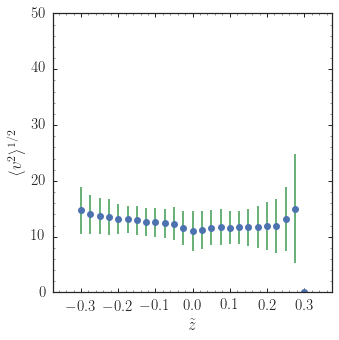

In [89]:
nbs=100  # number of sampling for bootstrap
numpy.random.seed(3)
v2_obs,v2_obs_noise,nstar =compute_madbsv2(z_data,vz_data,vz_err,z_obs,h_obs,nbs)
for ii,zo in enumerate(z_obs):
    print ' z,<v^2>^1/2,error,np=',zo,numpy.sqrt(v2_obs[ii]),numpy.sqrt(v2_obs_noise[ii]),nstar[ii]
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
bovy_plot.bovy_plot(z_obs,numpy.sqrt(v2_obs),'o',semilogy=False,
  xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle^{1/2}$',
  xrange=[np.min(z_obs)-h_obs,np.max(z_obs)+h_obs],yrange=[0.0,50.0],gcf=True)
errorbar(z_obs,numpy.sqrt(v2_obs),yerr=numpy.sqrt(v2_obs_noise),marker='None',ls='none',color=sns.color_palette()[1])

In [ ]:
import pyfits
# output fits file
# header
prihdr=pyfits.Header()
prihdr['h_obs']=h_obs
prihdu=pyfits.PrimaryHDU(header=prihdr)
tbhdu=pyfits.BinTableHDU.from_columns([\
  pyfits.Column(name='z_obs',format='E',array=z_obs),\
  pyfits.Column(name='v2_obs',format='E',array=v2_obs),\
  pyfits.Column(name='v2_obs_noise',format='E',array=v2_obs_noise)])
thdulist=pyfits.HDUList([prihdu,tbhdu])
thdulist.writeto('cylinder_v2m.fits',clobber=True)